# Time Series Analysis

Let's take a look at how to work with time series in Python

## Introduction


We begin with a simple definition of time series:

Therefore, the data is organized by relatively deterministic timestamps, and may, compared to random sample data, contain additional information that we can extract.

Let's import some libraries. First, we will need the statsmodels library, which has many statistical modeling functions, including time series.

### Importing the Libraries

In [3]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook



%matplotlib inline

As an example, let's look at real mobile game data. Specifically, we will look into ads watched per hour and in-game currency spend per day:

In [5]:
df_ads = pd.read_csv('dataset/ads.csv', index_col=['Time'], parse_dates=['Time'])
df_currency = pd.read_csv('dataset/currency.csv', index_col=['Time'], parse_dates=['Time'])

In [8]:
# checking the top 5 rows of df_ads dataset.

df_ads.head(5)

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


In [9]:
# checking the top 5 rows of df_cuurency dataset.

df_currency.head(5)

,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775


In [11]:
# checking the info of the df_ads

df_ads.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 2017-09-13 00:00:00 to 2017-09-21 23:00:00
Data columns (total 1 columns):
Ads    216 non-null int64
dtypes: int64(1)
memory usage: 3.4 KB


In [12]:
# checking the info of the df_currency

df_currency.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2017-05-01 to 2018-02-24
Data columns (total 1 columns):
GEMS_GEMS_SPENT    300 non-null int64
dtypes: int64(1)
memory usage: 4.7 KB


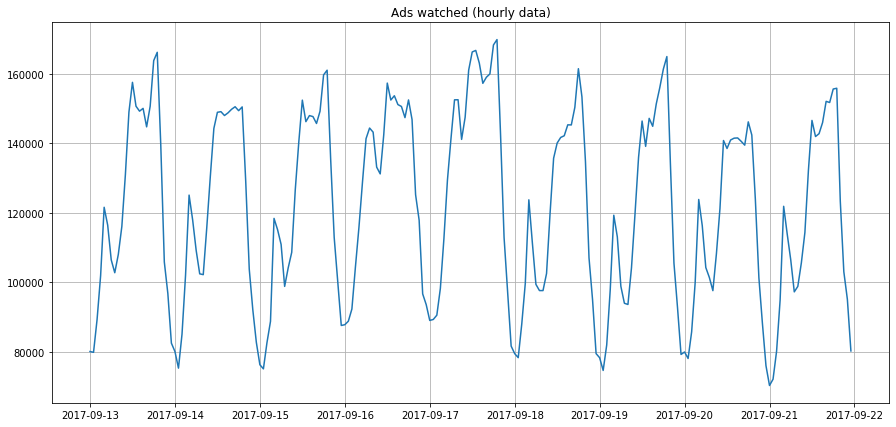

In [13]:
# Let's plot the ads watched hourly data of daily basis.

plt.figure(figsize = (15, 7))
plt.plot(df_ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

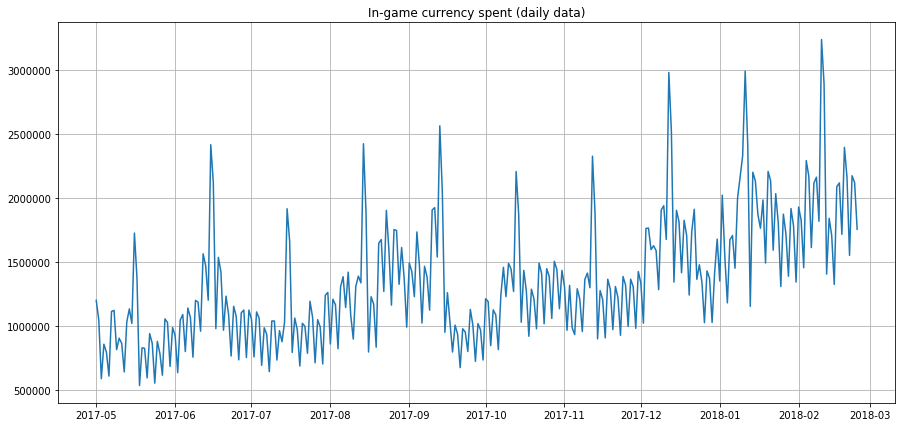

In [15]:
# Let's plot the gems spent data of daily basis.

plt.figure(figsize = (15, 7))
plt.plot(df_currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

### Forecast quality metrics


Before begining the forecasting, let's understand how to measure the quality of our predictions and take a look at the most commonly used metrics.

#### Importing the Quality Metrics.


In [16]:

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


After deciding the quality metrics, let's see what metrics we can use and how to translate the results for the final prediction. After that, one small detail remains - building the model.

### Move, Smooth, Evaluate

Let's start with a naive hypothesis: "tomorrow will be the same as today". However, instead of a model like  y^t = yt−1  (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), we will assume that the future value of our variable depends on the average of its  k  previous values. Therefore, we will use the moving average.

In [17]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(df_ads, 24) # prediction for the last observed day (past 24 hours)

116805.0

Unfortunately, we cannot make predictions far in the future -- in order to get the value for the next step, we need the previous values to be actually observed. But moving average has another use case - smoothing the original time series to identify trends. Pandas has an implementation available with DataFrame.rolling(window).mean(). The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.

In [18]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

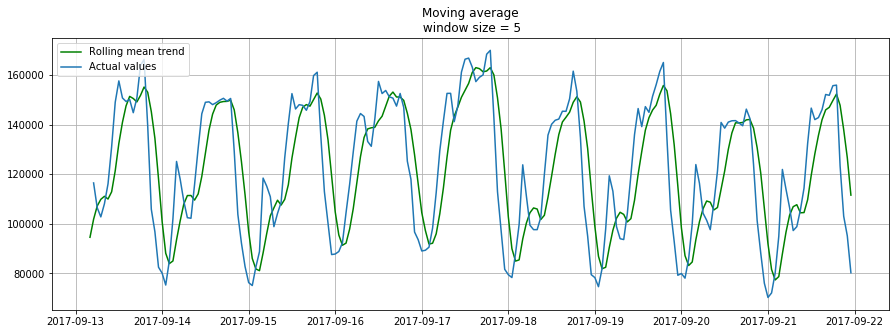

In [25]:
# Let;s Smooth by the previous 5 hours


plotMovingAverage(df_ads, 5)

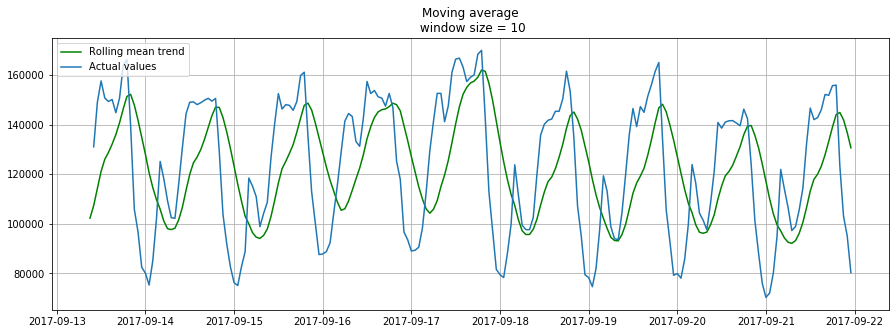

In [26]:
# Let;s Smooth by the previous 10 hours


plotMovingAverage(df_ads, 10)

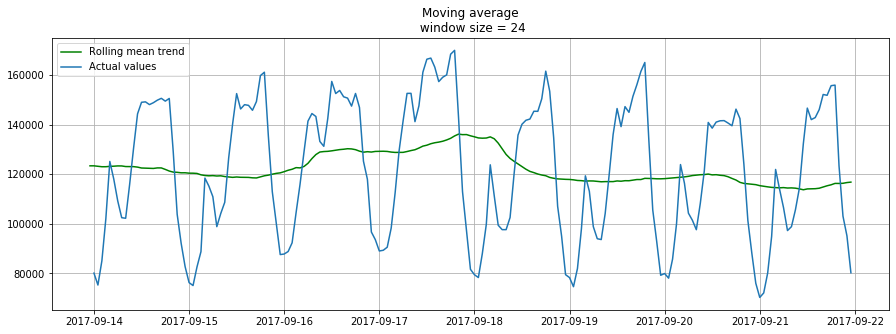

In [27]:
# Let;s Smooth by the previous 24 hours


plotMovingAverage(df_ads, 24)

When we applied daily smoothing on hourly data, we could clearly see the dynamics of ads watched. During the weekends, the values are higher (more time to play on the weekends) while fewer ads are watched on weekdays.

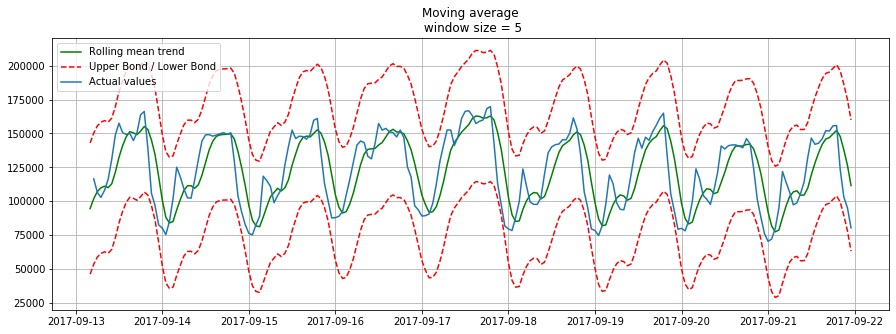

In [30]:
plotMovingAverage(df_ads, 5, plot_intervals=True)

Now, let's create a simple anomaly detection system with the help of moving average. Unfortunately, in this particular dataset, everything is more or less normal, so we will intentionally make one of the values abnormal in our dataframe

In [31]:
ads_anomaly = df_ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # say we have 80% drop of ads 

Let's see if this simple method can catch the anomaly.

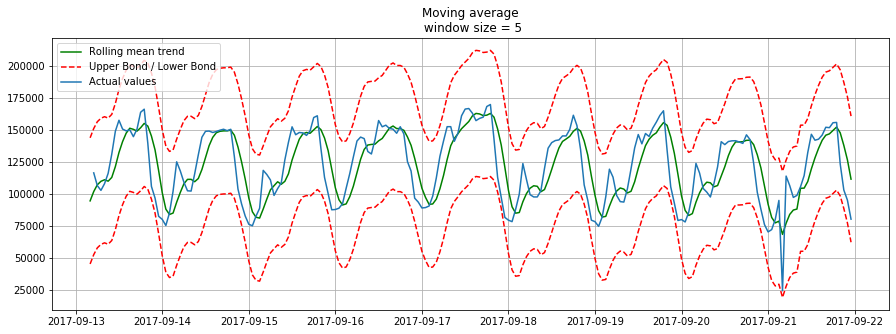

In [34]:
plotMovingAverage(ads_anomaly, 5, plot_intervals=True, plot_anomalies=True)

#### Let's find about the second series?

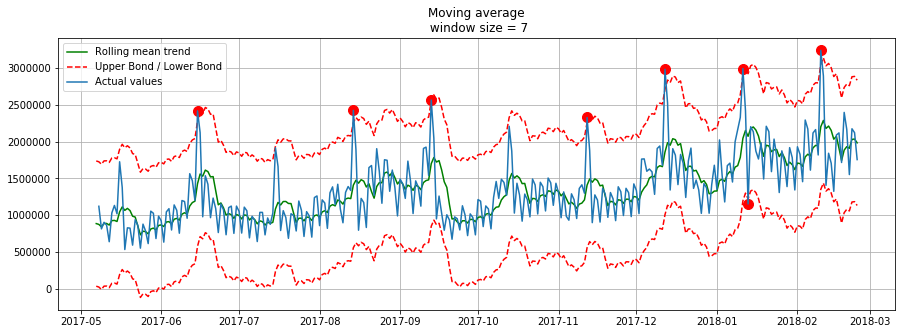

In [35]:
plotMovingAverage(df_currency, 7, plot_intervals=True, plot_anomalies=True) # weekly smoothing

Here, we can see the downside of our simple approach -- it did not capture the monthly seasonality in our data and marked almost all 30-day peaks as anomalies.

If you want to avoid false positives, it is best to consider more complex models.

In [36]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [38]:
weighted_average(df_ads, [0.6, 0.3, 0.1])

98423.0

### Exponential smoothing


Now, let's see what happens if, instead of weighting the last  k  values of the time series, we start weighting all available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for exponential smoothing.

Here the model value is a weighted average between the current true value and the previous model values. The  α  weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller  α  is, the more influence the previous observations have and the smoother the series is.

Exponentiality is hidden in the recursiveness of the function -- we multiply by  (1−α)  each time, which already contains a multiplication by  (1−α)  of previous model values.

In [39]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [40]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

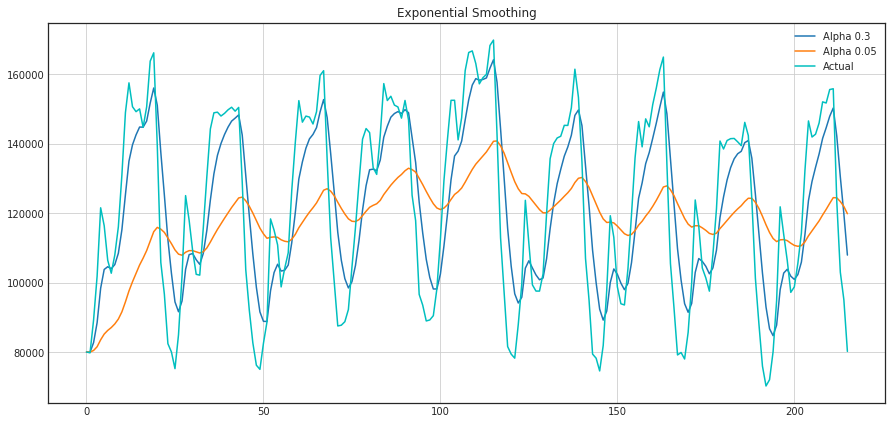

In [41]:
plotExponentialSmoothing(df_ads.Ads, [0.3, 0.05])

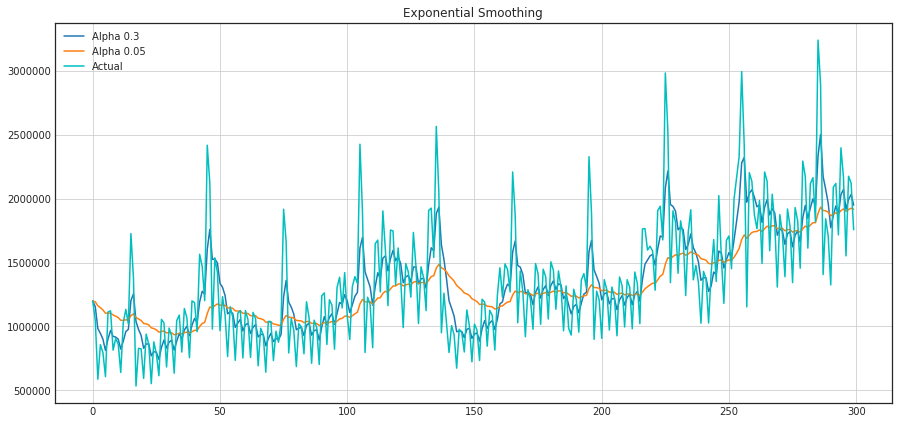

In [42]:
plotExponentialSmoothing(df_currency.GEMS_GEMS_SPENT, [0.3, 0.05])

### Double Exponential Smoothing

Up to now, the methods that we've discussed have been for a single future point prediction (with some nice smoothing). That is cool, but it is also not enough. Let's extend exponential smoothing so that we can predict two future points (of course, we will also include more smoothing).

Series decomposition will help us -- we obtain two components: intercept (i.e. level)  ℓ  and slope (i.e. trend)  b . We have learnt to predict intercept (or expected series value) with our previous methods; now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes. As a result, we get the following set of functions

The first one describes the intercept, which, as before, depends on the current value of the series. The second term is now split into previous values of the level and of the trend. The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend. In this case, the  β  coefficient is a weight for exponential smoothing. The final prediction is the sum of the model values of the intercept and

In [43]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

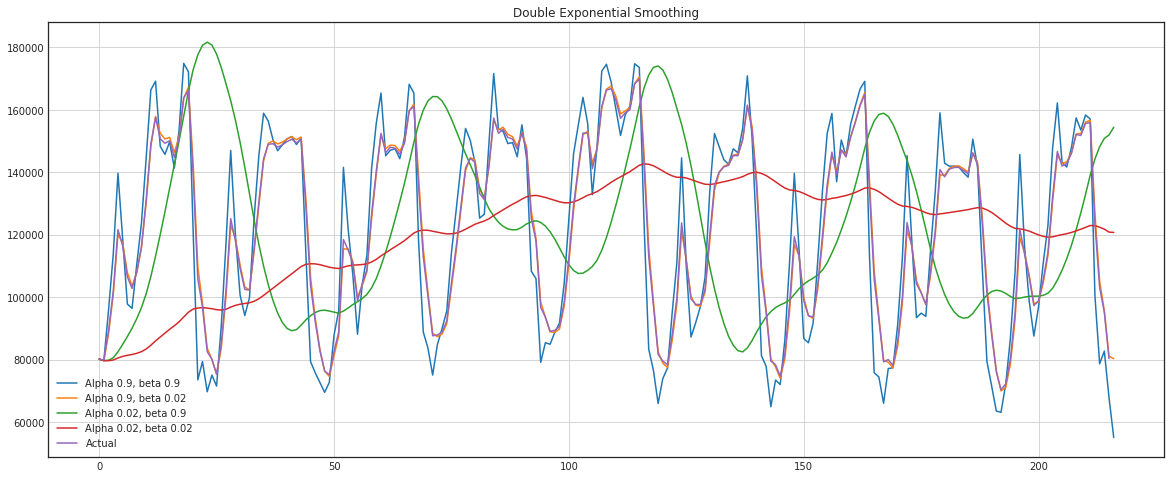

In [44]:
plotDoubleExponentialSmoothing(df_ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])

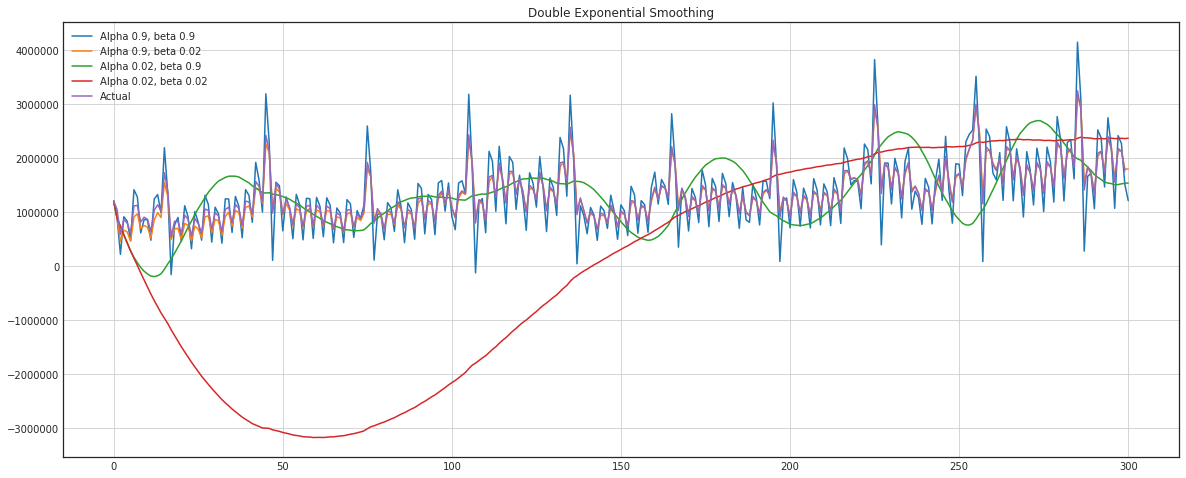

In [45]:
plotDoubleExponentialSmoothing(df_currency.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])